In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Week 1: Introduction

## Common Patterns in Time Series
- Trend: Specific Direction e.g., increasing
- Seasonality: repeat ar predictable intervals e.g., peaks at weekends
- Combination of both
- White noise: random values
- Autocorrelated: related with delayed copy of itself (lag)
- NonStationary: changing in behavior, train for short period (more data isn't always better)

In [3]:
def plot(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start: end], series[start: end], format)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.grid()

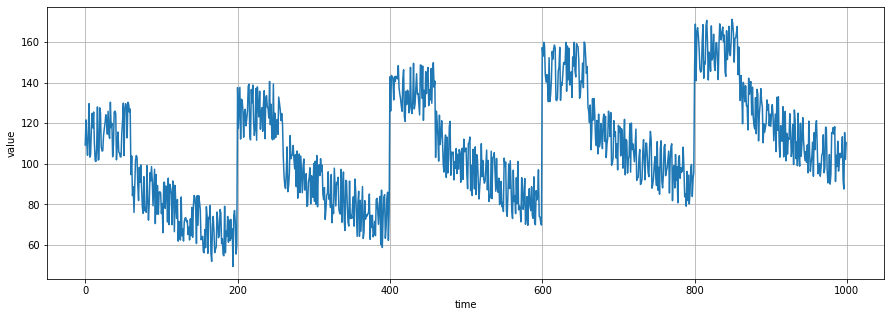

In [60]:
plt.figure(figsize=(15,5))
time = np.arange(1000)

# seasonality (period = 200)
period = 200
series = ((time) % period) / period
series = np.where(series < 0.3,  np.cos(series * 0.2 *  np.pi), 1 / np.exp( series))
# noise
series += (np.random.random(1000) * 0.3)
# trend
series += 0.0005 * time
# scaling
series *= 100

plot(time, series, end = None)

## Fixed Partitioning

For seasonal data, all splits must contain (int * periods)

train is the first & larger part

validation in the middle

test is the most recent part (often the future)

also: `Roll-Forward Partitioning`
short training period, gradually increase it (day at a time)

In [57]:
split_time = 800
ime_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
# plot(time_train, x_train)
# plot(time_valid, x_valid)

## Naive Forecasting

Metrics:
145.70082349197364
9.362195333507172


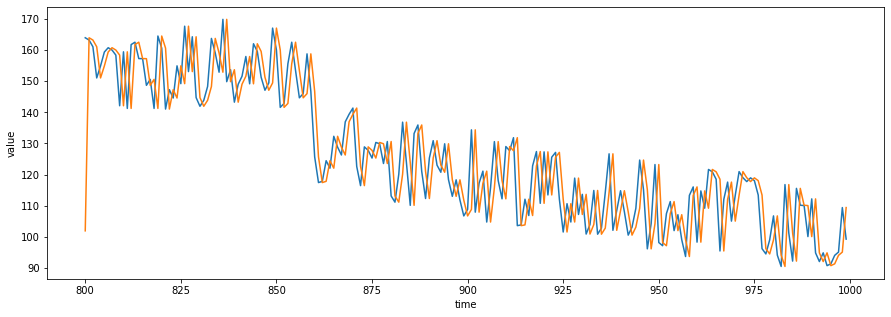

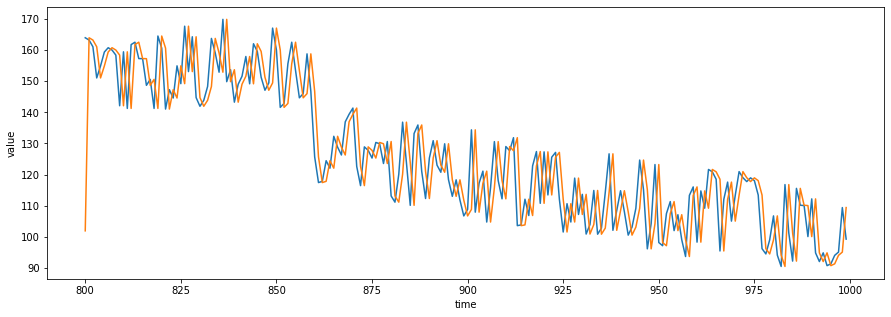

In [59]:
naive_forecasting = series[split_time - 1:-1]

plt.figure(figsize=(15,5))
plot(time_valid, x_valid)
plot(time_valid, naive_forecasting)

# Zoom
plt.figure(figsize=(15,5))
plot(time_valid, x_valid, start = 0, end = 200)
plot(time_valid, naive_forecasting, start = 0, end = 200)

print("Metrics:")
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecasting).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecasting).numpy())

## Moving Average
no the noise but doesn't anticipate trend or seasonality

(990,)
(200,)
Metrics:
205.29211499159203
10.465824904160739


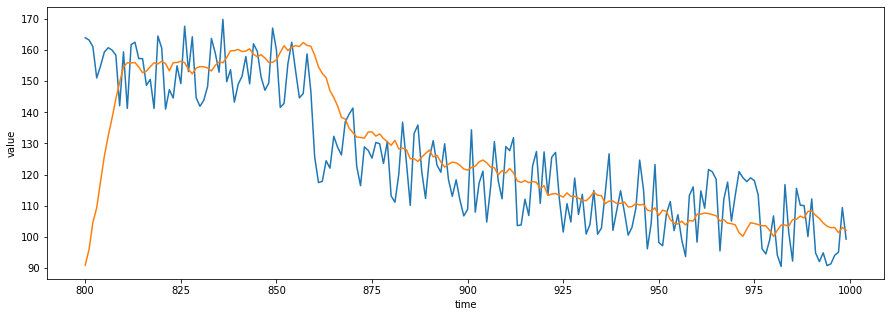

In [83]:
window_size = 10
moving_avg = []
for t in range(len(series) - window_size):
    moving_avg.append(series[t:t + window_size].mean())

moving_avg = np.array(moving_avg)
print(moving_avg.shape)
# last 200 values
moving_avg = moving_avg[split_time - window_size:]
print(moving_avg.shape)

plt.figure(figsize=(15,5))
plot(time_valid, x_valid)
plot(time_valid, moving_avg)

print("Metrics:")
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

## Differencing
1. remove trend and seasonality (t - (t-period))
2. get moving average
3. add (t - period) (can add moving avg for this too)
4. original timeseries

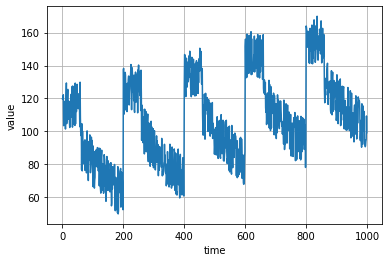

In [47]:
plot(time, series)

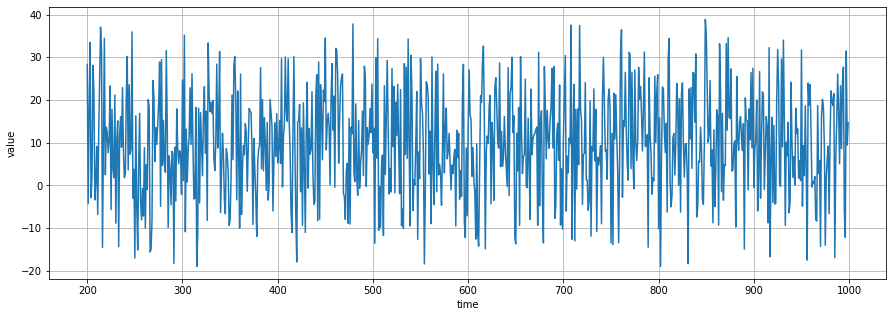

In [89]:
# Remove trend and seasonality
# t - (t - 200) ➡️ each period - the prev period (last 4 periods - first 4 periods)
diff_series = series[period:] - series[:-period]
plt.figure(figsize=(15,5))
plot(time[period:], diff_series)

In [90]:
split_time - period

600

(790,)


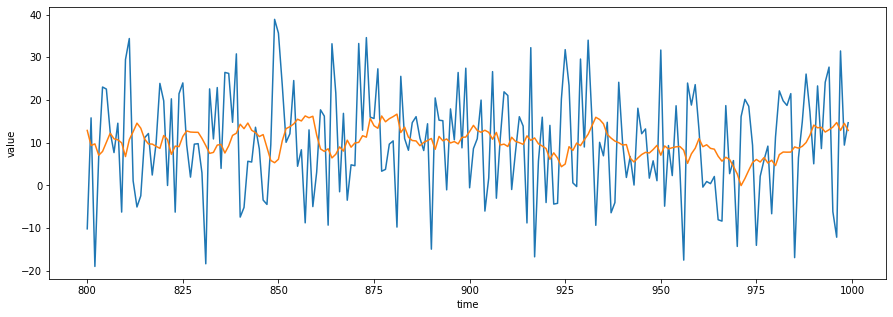

In [91]:
# get moving average
window_size = 10
diff_moving_avg = []
for t in range(len(diff_series) - window_size):
    diff_moving_avg.append(diff_series[t:t + window_size].mean())

diff_moving_avg = np.array(diff_moving_avg)
print(diff_moving_avg.shape)

diff_series = diff_series[split_time - period:]
diff_moving_avg = diff_moving_avg[split_time - period - window_size:]

plt.figure(figsize=(15,5))

plot(time_valid, diff_series)
plot(time_valid, diff_moving_avg)

# print("Metrics:")
# print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg).numpy())
# print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg).numpy())

In [92]:
diff_moving_avg.shape

(200,)

Metrics:
181.43193932818994
11.296892971006127


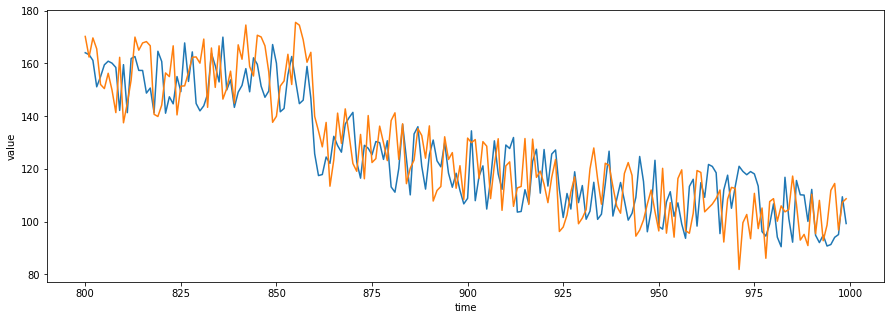

In [97]:
# add (t - 200) (can add moving avg for this too, but not added here)
# series[800 - 200 : - 200] ➡️ series [600 :800] 
diff_moving_avg_plus_past = diff_moving_avg + series[split_time - period:-period]

plt.figure(figsize=(15,5))

plot(time_valid, x_valid)
plot(time_valid, diff_moving_avg_plus_past)

print("Metrics:")
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())